# Style Transfer with PyTorch

In [1]:
%matplotlib inline

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms as tf
import torch.nn.functional as F

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

All pre-trained models in PyTorch expect input images pixels to be in the [0, 1] range normalized using this mean and std:  
<b>mean = (0.485, 0.456, 0.406)  
std = (0.229, 0.224, 0.225)</b>

In [4]:
def transformation(img, mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)):
    
    tasks = tf.Compose([
        tf.Resize(256),
        tf.ToTensor(),
        tf.Normalize(mean, std)
    ])
    
    img = tasks(img)
    img = img.unsqueeze(0)
    
    return img
    

In [5]:
content_img = Image.open("cat.jpg").convert("RGB")
style_img = Image.open("starry_night.jpg").convert("RGB")

In [6]:
content_img = transformation(content_img).to(device)
style_img = transformation(style_img).to(device)

In [7]:
class UnNormalize(object):
    def __init__(self, mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [8]:
def tensor_to_image(tensor, mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)):
    
    image = tensor.clone()
    unorm = UnNormalize(mean = mean, std = std)
    image = unorm(image)
    image = image.detach()
    image = image.cpu().numpy().squeeze()
    
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    
    return image    

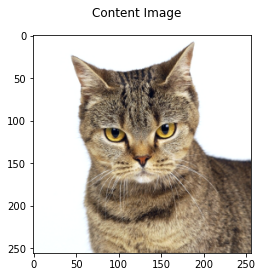

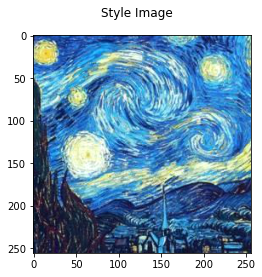

In [9]:
img = tensor_to_image(content_img)
fig = plt.figure()
fig.suptitle("Content Image")
plt.imshow(img)

img = tensor_to_image(style_img)
fig = plt.figure()
fig.suptitle("Style Image")
plt.imshow(img)

In [10]:
LAYERS_OF_INTEREST = {'0': 'conv1_1',
                      '5': 'conv2_1',
                      '10': 'conv3_1',
                      '19': 'conv4_1',
                      '21': 'conv4_2',
                      '28': 'conv5_1'}

In [11]:
def apply_model_and_extract_features(image, model):
    
    x = image
    
    features = {}
    
    for name, layer in model._modules.items():
        x = layer(x)
        
        if name in LAYERS_OF_INTEREST:
            features[LAYERS_OF_INTEREST[name]] = x
            
    return features

In [12]:
content_img_features = apply_model_and_extract_features(content_img, vgg)
style_img_features = apply_model_and_extract_features(style_img, vgg)

In [13]:
def calculate_gram_matrix(tensor):
    
    _, channels, height, width = tensor.size()
    
    tensor = tensor.view(channels, height * width)
    
    gram_matrix = torch.mm(tensor, tensor.t())
    
    gram_matrix = gram_matrix.div(channels * height * width) #normalize so large feature maps don't  
                                                             #disproportionately affect the result
    return gram_matrix

In [14]:
style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in style_img_features}

In [15]:
weights = {'conv1_1': 1.0, 
           'conv2_1': 0.75, 
           'conv3_1': 0.35, 
           'conv4_1': 0.25, 
           'conv5_1': 0.15}
# Earlier layers contain more information so are more important

In [28]:
target = content_img.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([target], lr=3e-3)

content_weight = 1
style_weight = 1e15

Epoch 0: Content_loss: 0.000000 - Style_loss: 167761.859375
Total loss:  167761.859375


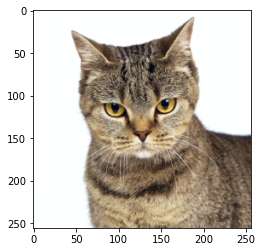

Epoch 1000: Content_loss: 13.391632 - Style_loss: 6324.967285
Total loss:  6338.35888671875


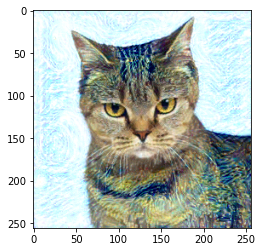

Epoch 2000: Content_loss: 14.243601 - Style_loss: 2249.254639
Total loss:  2263.498291015625


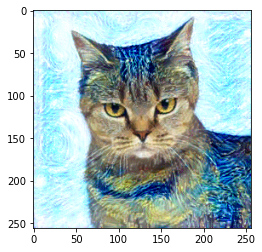

Epoch 3000: Content_loss: 14.570205 - Style_loss: 1352.489990
Total loss:  1367.0601806640625


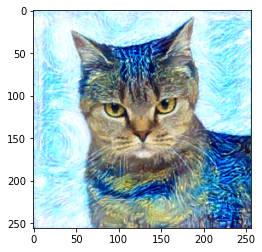

Epoch 4000: Content_loss: 14.757771 - Style_loss: 926.255127
Total loss:  941.0128784179688


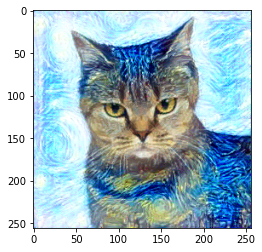

Epoch 5000: Content_loss: 14.922388 - Style_loss: 687.396606
Total loss:  702.3189697265625


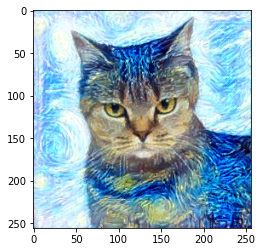

Epoch 6000: Content_loss: 15.040918 - Style_loss: 541.405701
Total loss:  556.4465942382812


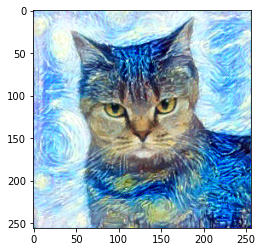

Epoch 7000: Content_loss: 15.138381 - Style_loss: 442.496796
Total loss:  457.6351623535156


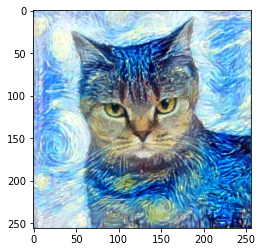

Epoch 8000: Content_loss: 15.238452 - Style_loss: 375.418274
Total loss:  390.65673828125


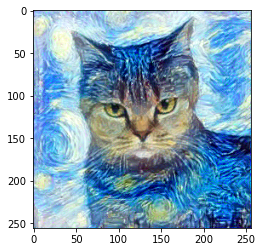

Epoch 9000: Content_loss: 15.312798 - Style_loss: 333.538818
Total loss:  348.85162353515625


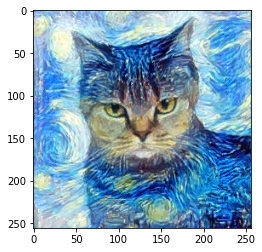

Epoch 10000: Content_loss: 15.388887 - Style_loss: 305.965912
Total loss:  321.35479736328125


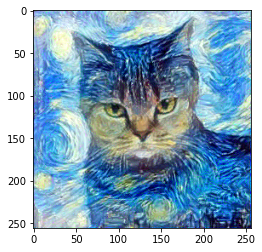

In [29]:
show = 1000
steps = 10000  

for ii in range(0, steps+1):
    
    target_features = apply_model_and_extract_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_img_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in weights:
        target_feature = target_features[layer]
        target_gram = calculate_gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_features_gram_matrix[layer]
        layer_style_loss = weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show == 0:
        print("Epoch {}: Content_loss: {:4f} - Style_loss: {:4f}".format(ii, content_weight * content_loss,
                                                                        style_weight * style_loss))
        print('Total loss: ', total_loss.item())
        plt.imshow(tensor_to_image(target))
        plt.show()

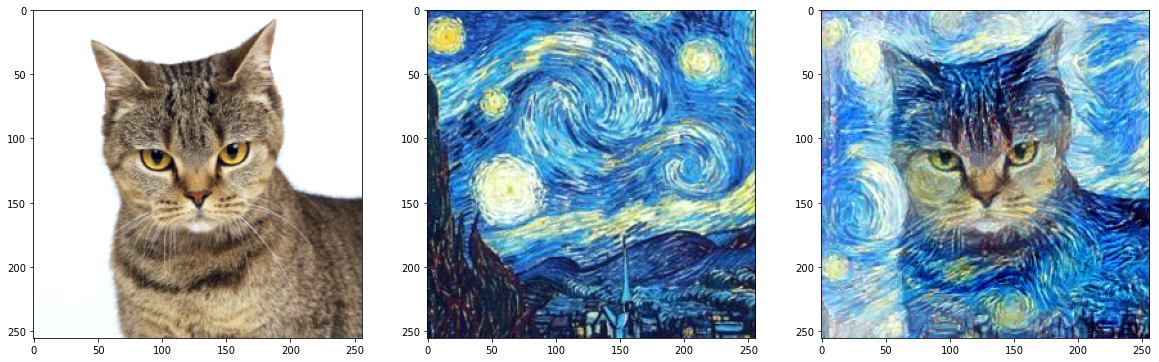

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(tensor_to_image(content_img))
ax2.imshow(tensor_to_image(style_img))
ax3.imshow(tensor_to_image(target))